In [1]:
import xml.etree.ElementTree as ET
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler
import json

# Function to create mapping between words and corresponding text references

In [2]:
# Returns list of dictionaries containing words and their corresponding references
# The first layer of lists contains individual lines of text 
# The second layer of lists contains individual words in each line of text 

# words_arr: 
# [[{word : "And", refs: ["t0", "t1"]} , {word: "He", refs: ["t2", "t3"]}], <- Line 1
#   [{...}, {...}], <- Line 2
#   [{...}, {...}], <- Line 3
# ]

# Also returns a list of line ids which correspond the the lines in the order that they occur 
# lines: ["0", "1", "2", ...]

def read_ink(path):
    tree = ET.parse(path)
    root = tree.getroot()

    traceView = root.find("traceView")

    traceView2 = traceView.findall("traceView")

    textBlockRoots = []

    for t in traceView2:
        annotation = t.find("annotation")

        if (annotation.text == "Textblock"):
            textBlockRoots.append(t)

    words_arr = []
    
    # Array of line tags
    lines = []
    curr_line = 0

    for textBlock in textBlockRoots:
        #For each textline
        for textLine in textBlock.findall("traceView"):
            line_arr = []
            string = textLine[1].text

            lines.append(str(curr_line))
            curr_line += 1

            # For each word in the textline 
            for i in range(2, len(textLine)):
                wordElement = textLine[i]
                word = wordElement[1].text
                
                word_dict = {}

                if word is not None:
                    word_dict["word"] = word
                    word_dict["refs"] = []

                    refs = wordElement.findall('traceView')
                
                    for ref in refs:
                        if 'traceDataRef' in ref.attrib:
                            # Remove the initial '#' from the ref xml tag
                            word_dict["refs"].append(ref.attrib['traceDataRef'][1:])

                    line_arr.append(word_dict)

            words_arr.append(line_arr)

    assert(len(words_arr) == len(lines))                
    return words_arr, lines
    

In [3]:
for f in glob.glob("../data/datasets/*1*.inkml"):
    print(f)

    textLines, lines = read_ink(f)

    for textLine in textLines:
        for word_dict in textLine:
            print(word_dict["word"], end=" ")
        print()
    print()


../data/datasets/001f.inkml
And he had a feeling - thanks to the 
girl - that things would get worse 
before they got better . They had the 
house cleaned up by noon , and Wilson 
sent the boy out to the meadow to 
bring in the horses . 

../data/datasets/001g.inkml
And he had a feeling - 
thanks to the girl - 
that things would get worse 
before they got better . 
They had the house cleaned 
by noon , and Wilson sent the 
boy out to the meadow to 
bring in the horses . 

../data/datasets/001.inkml
And he had a feeling - thanks to the girl - 
that things would get worse before they got 
better . 
They had the house 
cleaned up by noon , 
and Wilson sent 
the boy out to the meadow to bring in the 
horses . 
He stoat on the porch 
and watched him struggling 
with the heavy harness , 
and finally went over to help him . 

../data/datasets/001e.inkml
And he had a feeling - thanks to the girl - 
that things would get worse before 
they got better . They had the house 
cleaned up by noon , a

# Functions to get final text reference for last assessable word

In [4]:
def get_final_ref(filename):
    textLines, lines = read_ink(filename)

    for textLine in textLines:
        for word_dict in textLine:
            word = word_dict["word"]
            
            if word == "better":
                return word_dict['refs'][-1]
               
    return None

# Returns the last tag for the word "better"
def get_final_refs():
    final_refs = {}
    
    for f in glob.glob("../data/datasets/*1*.inkml"):
        final_ref = get_final_ref(f)
        filename = f.split("/")[3].split(".")[0]
        final_refs[filename] = final_ref

    return final_refs


# Function to load raw txt data contain time series (not formatted)

In [5]:
# Returns a dict that maps ref id -> digital ink time series
def get_digital_ink(path):
    tree = ET.parse(path)
    root = tree.getroot()
    traces = root.findall("trace")

    digital_ink_dict = {}

    for trace in traces:
        digital_ink_dict[trace.attrib['{http://www.w3.org/XML/1998/namespace}id']] = trace.text

    return digital_ink_dict

# Functions to format raw time series data (formatted time series is not evenly spaced)

In [6]:
def add_value(series, v):
    series.append(series[len(series) - 1] + v)

def add_initial_point(data, x, y, t, p):
    starting_data = data.split(" ")

    start_x = float(starting_data[0])
    start_y = float(starting_data[1])
    start_t = float(starting_data[2])
    start_p = float(starting_data[3])

    x.append(start_x)
    y.append(start_y)
    t.append(start_t)
    p.append(start_p)

In [7]:
# Converts a time series of v,v',v" into a time series of purely v values 
# Basically converts first and second derivatives into normal points
# This function DOES NOT ensure time series are evenly spaced

# Inputs: 
# raw_time_series: ["1,5,3,5", 2',3',5',2', .... ]
# transformation_matrix: 4x4 numpy array

# Outputs: 
# x,y,t,p data 
def construct_time_series(raw_time_series, transformation_matrix):
    raw_time_series = raw_time_series.strip()
    points = raw_time_series.split(",")

    x, y, t, p = [], [], [], []
    
    # Starting data
    if len(points) >= 1:
        add_initial_point(points[0], x, y, t, p)

    # 2nd set of data (1st derivative)
    if len(points) >= 2:
        trace_v = points[1].split("\'")

        v_x = float(trace_v[1])
        v_y = float(trace_v[2])
        v_t = float(trace_v[3])
        v_p = float(trace_v[4])

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    # 3rd set of data (2nd derivative)
    if len(points) >= 3:
        trace_acc = points[2].split("\"")

        v_x += float(trace_acc[1])
        v_y += float(trace_acc[2])
        v_t += float(trace_acc[3])
        v_p += float(trace_acc[4]) 

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    # for all other sets of data 
    for i in range(3, len(points)):
        values = re.findall("-?\d*\.?\d+", points[i])

        v_x += float(values[0])
        v_y += float(values[1])
        v_t += float(values[2])
        v_p += float(values[3])

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    time_series = np.array([x,y,t,p])
    time_series = np.swapaxes(time_series,0,1)

    return transform_time_series(time_series, transformation_matrix)

# Inputs:
# time_series: (4xn np_array)
# [ x ...
#   y ...
#   t ...
#   p ... ]
#
# matrix: 4x4 transformation matrix (np_array)

# Outputs: x,y,t,p series of data (4 arrays)
def transform_time_series(time_series,matrix): 
    # An affine transformation uses the following procedure
    # v = M . u + b
    # M -> 4x4 matrix (first 4 columns of the matrix in the xml tree)
    # b -> 4x1 matrix (last column of the matrix in the xml tree)
    # u -> 4xn matrix (time series data of x,y,t,p
    transformed_data = np.dot(time_series, matrix[:,:-1]) + matrix[:,-1]

    return transformed_data[:,0], transformed_data[:,1], transformed_data[:,2], transformed_data[:,3]


## Functions to load transformation matrices

In [8]:
# Generates a transformation matrix for a particular xml file
def generate_matrices(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()

    definitions = root.find("definitions")

    canvasTransform = definitions.find("canvasTransform")
    mapping = canvasTransform.find("mapping")

    if mapping.attrib["type"] == "identity":
        return np.array([[1,0,0,0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0]], dtype=float)

    matrix = mapping.find("matrix").text

    rows = matrix.split(",")

    M = np.expand_dims(np.fromstring(rows[0],sep = " "), 0)

    for i in range(1, len(rows) - 1):
        row = rows[i]
        M = np.concatenate((M, np.expand_dims(np.fromstring(row,sep = " "), 0))) 

    # Case where axes are swapped
    if M[0][0] - 0 < 0.000001:
        M[0][1] = -M[0][1]
        M[1][0] = -M[1][0]
    
    return M
    
# Gets transformation matrix from dictionary of matrices
# filepath is the full filepath
def get_transformation_matrix(matrices, filepath):
    if filepath not in matrices:
        matrices[filepath] = generate_matrices(filepath)

    return matrices[filepath]

# Functions to format time series to evenly spaced data

In [9]:
# Fill time gaps for 1D array with time dimensions as shown below
def get_time_gaps(t):
    start_t = t[0]
    end_t = t[len(t) - 1]

    return np.arange(start_t, end_t, 0.013)

# Visualise and save digital ink as png files

Saving image for ../data/datasets/001f.inkml


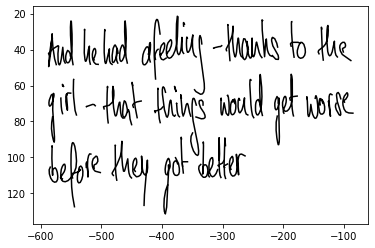

Saving image for ../data/datasets/001g.inkml


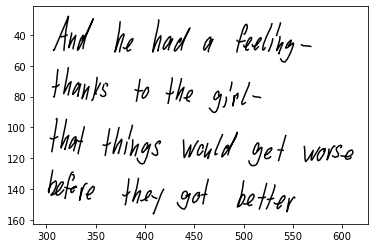

Saving image for ../data/datasets/001.inkml


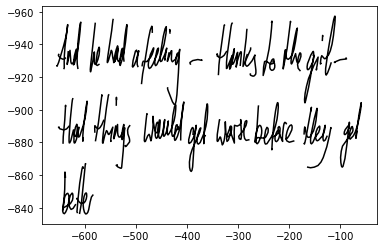

Saving image for ../data/datasets/001e.inkml


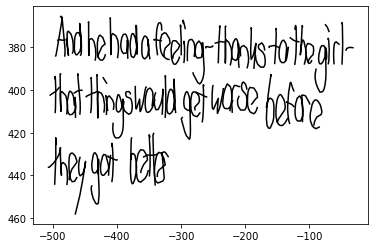

Saving image for ../data/datasets/001a.inkml


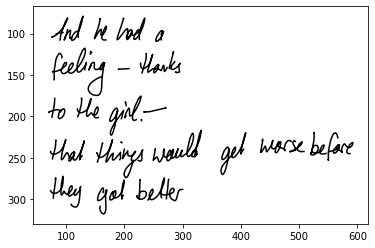

Saving image for ../data/datasets/001b.inkml


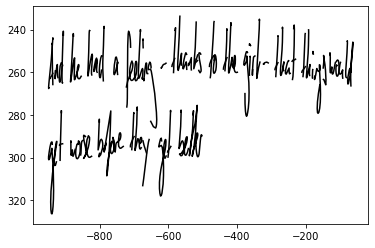

Saving image for ../data/datasets/001c.inkml


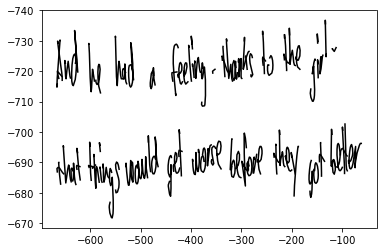

Saving image for ../data/datasets/001d.inkml


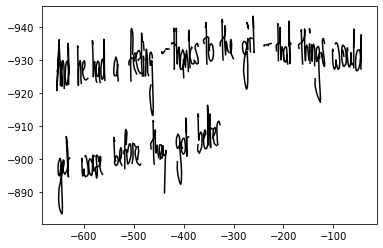

In [10]:
final_refs = get_final_refs()

# Create dict to stop repititive calls to read xml file
matrices = {}

# Save image to png file
def save_image(f, final_refs):
    filename = f.split("/")[3].split(".")[0]

    textLines, lines = read_ink(f)
    ref_dict = get_digital_ink(f)

    for textLine in textLines:
        for word_dict in textLine:
            for ref in word_dict["refs"]:
                x,y,t,p = construct_time_series(ref_dict[ref].strip(), get_transformation_matrix(matrices, f))
                
                # Not necessary if we are only visualising the image 
                # Create evenly spaced time series for each individual word
                # t_filled = get_time_gaps(t)
                # x_filled = np.interp(t_filled, t, x)
                # y_filled = np.interp(t_filled, t, y)

                plt.plot(x, y, color = "black")

                if ref == final_refs[filename]:
                    print("Saving image for", f)
                    plt.gca().invert_yaxis()
                    # plt.axis("off")
                    # plt.savefig("../data/screenshots/" + filename + ".png", facecolor = "w", bbox_inches="tight", dpi=250)
                    plt.show()
                    return
            
    print("Image not generated for", f)
    return

!mkdir -p ../data/screenshots/

for f in glob.glob("../data/datasets/*1*.inkml"): 
    fig = save_image(f, final_refs)

# Create Evenly Spaced Time Series for Text Analysis 

In [10]:
final_refs = get_final_refs()

# Create dict to stop repititive calls to read xml file
matrices = {}

# Save image to png file
def merge_textLines(f, final_refs):
    filename = f.split("/")[3].split(".")[0]

    textLines, lines = read_ink(f)
    ref_dict = get_digital_ink(f)

    merged_textLines = {} 
    merged_textLines["x"] = np.array([])
    merged_textLines["y"] = np.array([])
    merged_textLines["t"] = np.array([])
    merged_textLines["p"] = np.array([])

    for word_dict in textLines[0]:
        for ref in word_dict["refs"]:
            x,y,t,p = construct_time_series(ref_dict[ref].strip(), get_transformation_matrix(matrices, f))

            merged_textLines["x"] = np.append(merged_textLines["x"], x)
            merged_textLines["y"] = np.append(merged_textLines["y"], y)
            merged_textLines["t"] = np.append(merged_textLines["t"], t)
            merged_textLines["p"] = np.append(merged_textLines["p"], p)

    # Determine the y-mean and x-last of the first line 
    x_right_last = np.max(merged_textLines["x"])
    y_mean_1 = np.mean(merged_textLines["y"])

    reached_end = False
    
    # For each word in a line append to merged textLine 
    # When a new line is encountered, keep track of last x value as well as mean y value 
    for i in range(1,len(textLines)):
        textLine = textLines[i]

        # We first need to transform all strokes in a line into a single continuous time series before we can merge two lines together 
        line = {}
        line["x"] = np.array([])
        line["y"] = np.array([])
        line["t"] = np.array([])
        line["p"] = np.array([]) 

        for word_dict in textLine:
            for ref in word_dict["refs"]:
                x,y,t,p = construct_time_series(ref_dict[ref].strip(), get_transformation_matrix(matrices, f))

                line["x"] = np.append(line["x"], x)
                line["y"] = np.append(line["y"], y)
                line["t"] = np.append(line["t"], t)
                line["p"] = np.append(line["p"], p)


                if ref == final_refs[filename]:
                    reached_end = True
                    break
            
            if reached_end == True: 
                break


        # Get the x-start and y_mean of the new line 
        x_left_first = np.min(line["x"])
        line["x"] = line["x"] + (x_right_last - x_left_first)
        x_right_last = np.max(line["x"])

        y_mean_curr = np.mean(line["y"])
        line["y"] = line["y"] - y_mean_curr + y_mean_1 

        merged_textLines["x"] = np.append(merged_textLines["x"], line["x"])
        merged_textLines["y"] = np.append(merged_textLines["y"], line["y"])
        merged_textLines["t"] = np.append(merged_textLines["t"], line["t"])
        merged_textLines["p"] = np.append(merged_textLines["p"], line["p"])

        if reached_end == True:
            return merged_textLines
            
    print("End not reached when merging lines together into one single line")
    return {} 


# textLines: a dictionary of 4 time series arrays {x: [],y: [],t: [],p: []}
def create_evenly_spaced_series(textLines):
    # Create evenly spaced time series 
    x = textLines["x"]
    y = textLines["y"]
    t = textLines["t"]
    p = textLines["p"]

    t_filled = get_time_gaps(t)
    x_filled = np.interp(t_filled, t, x)
    y_filled = np.interp(t_filled, t, y)
    p_filled = np.interp(t_filled, t, p)

    textLines["x"] = x_filled
    textLines["y"] = y_filled
    textLines["t"] = t_filled
    textLines["p"] = p_filled

    return textLines

def normalise_textLine(textLine):
    X = np.swapaxes(np.array([textLine["x"], textLine["y"], textLine["t"], textLine["p"]]), 0 , 1)

    scaler = StandardScaler().fit(X)

    # X_norm = normalize(X, axis=0)
    X_scaled = scaler.transform(X)

    textLine["x"] = X_scaled[:, 0]
    textLine["y"] = X_scaled[:, 1]
    textLine["t"] = X_scaled[:, 2]
    textLine["p"] = X_scaled[:, 3]
    return textLine

001f


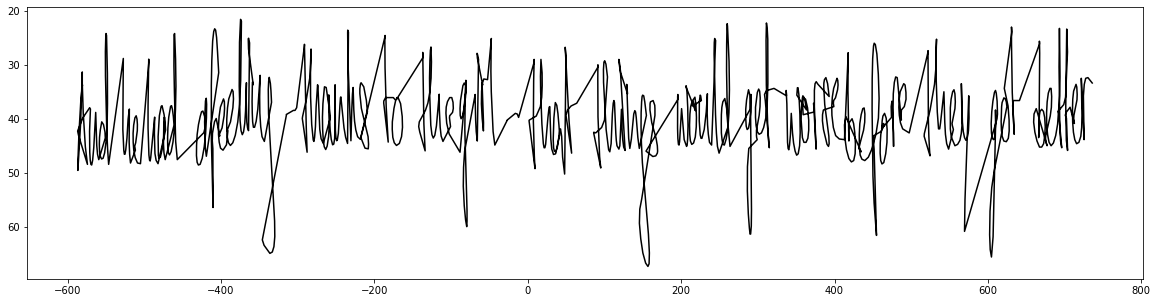

001g


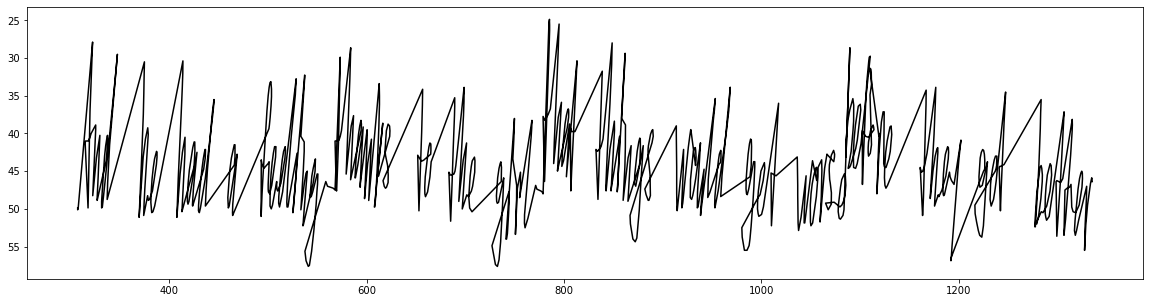

001


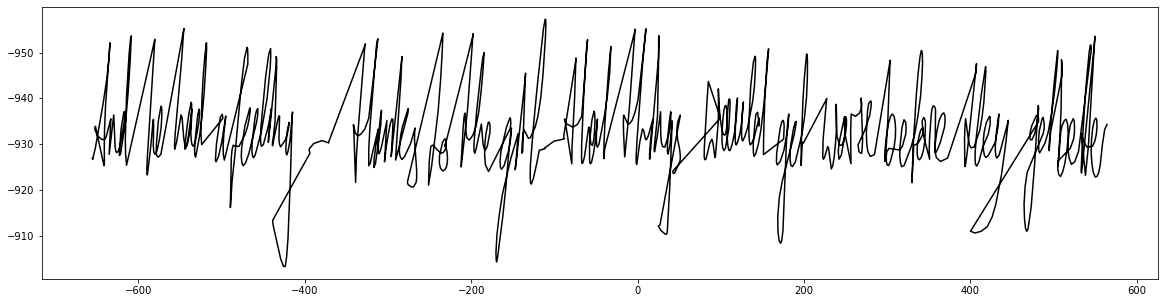

001e


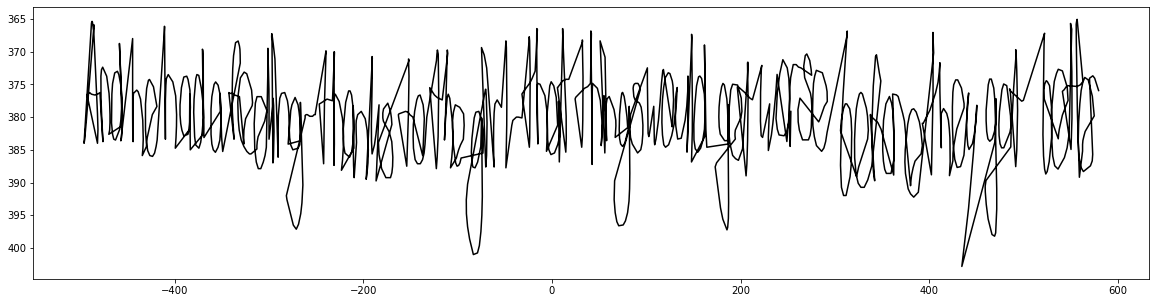

001a


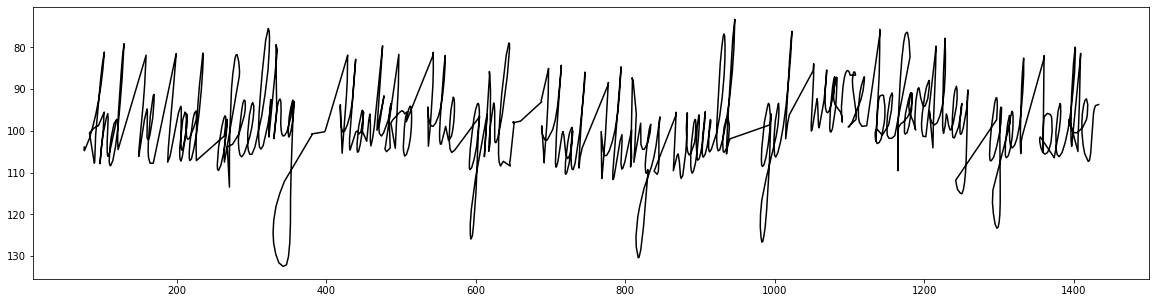

001b


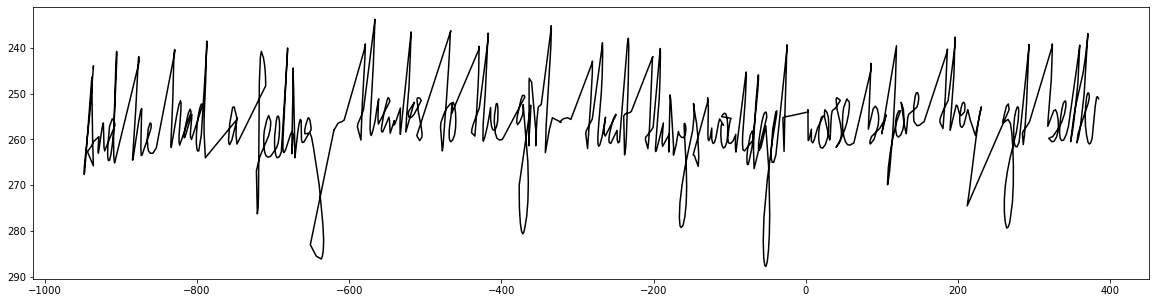

001c


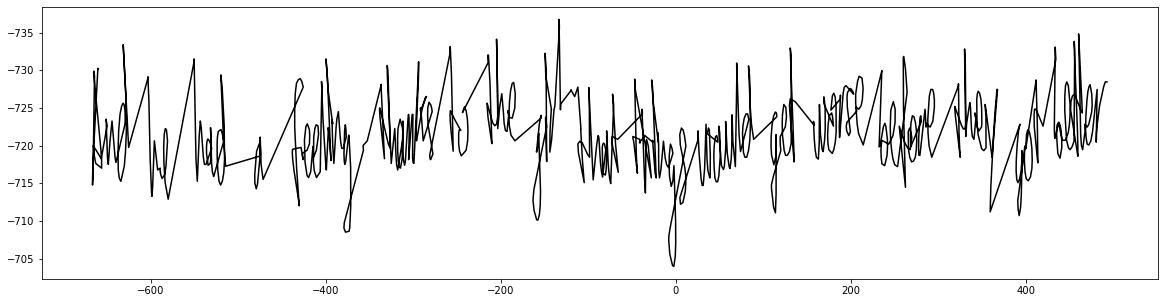

001d


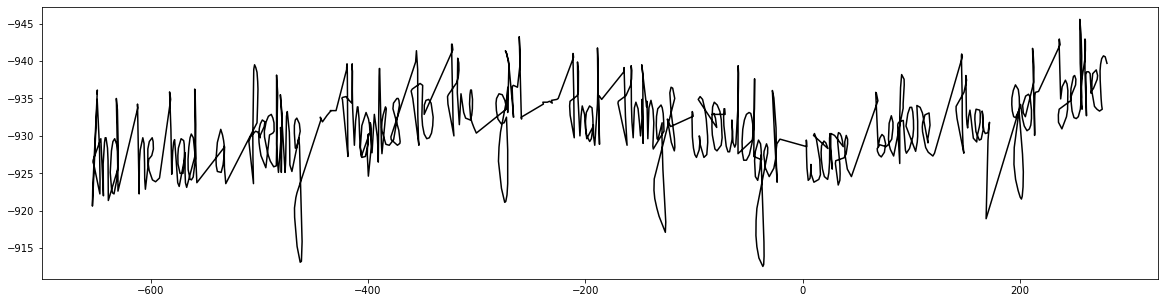

In [12]:
for f in glob.glob("../data/datasets/*1*.inkml"): 
    # Dont normalise dataset
    dataset_series = merge_textLines(f, final_refs)
    
    # merged_textLine = merge_textLines(f, final_refs)
    # evenly_spaced_textLine = create_evenly_spaced_series(merged_textLine)
    # dataset_series = normalise_textLine(evenly_spaced_textLine)

    # Make numpy arrays json serialisable
    dataset_series["x"] = dataset_series["x"].tolist()
    dataset_series["y"] = dataset_series["y"].tolist()
    dataset_series["t"] = dataset_series["t"].tolist()
    dataset_series["p"] = dataset_series["p"].tolist()

    filename = f.split("/")[3].split(".")[0]

    print(filename)
    
    plt.figure(figsize=(20,5))
    plt.plot(dataset_series["x"], dataset_series["y"], color = "black")
    plt.gca().invert_yaxis()
    plt.show()

    save_target = "../data/formatted_unnormalised_datasets/" + filename + ".json"

    with open(save_target, 'w') as fp:
        json.dump(dataset_series, fp)

# Upload Data to Firestore

Uploads entirety of inkml files to firestore including line structure. 
Ink has been transformed if necessary and all individual ink refs have been evenly spaced. 
Ink has not been normalised. 

In [14]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

json_file = glob.glob("*.json")[0]

cred = credentials.Certificate(json_file)
firebase_admin.initialize_app(cred, {
    'projectId': 'digital-pen-746a6',
})

db = firestore.client()

In [17]:
# Create empty matrix dictionary
matrices = {}

# Upload data to firebase
for filename in glob.glob("../data/datasets/*1e.inkml"):
    print("Uploading", filename)

    raw_file = filename.split("/")[3]
    file_ref = db.collection("files").document(raw_file)

    batch = db.batch()

    lines_arr, lines = read_ink(filename)
    ref_dict = get_digital_ink(filename)

    # Add line ids to root level directory
    data = {
        "line_ids": lines
    }

    batch.set(file_ref, data)

    # Add individual text lines to subcollections
    for i in range(0, len(lines)):
        line_id = lines[i]
        line_data = lines_arr[i]

        word_ids = [str(j) for j in range(0, len(line_data))]

        words = {}

        words["word_ids"] = word_ids

        for j in range(0, len(line_data)):
            words[word_ids[j]] = line_data[j]

        line_ref = file_ref.collection("lines").document(line_id)

        batch.set(line_ref, words)

    # Add digital ink data with references as keys
    for ref in ref_dict.keys():
        # Load transformation matrix for inkml file
        matrix = get_transformation_matrix(matrices, filename)
        x, y, t, p = construct_time_series(ref_dict[ref].strip(), matrix)

        # Create evenly spaced time series for each individual word
        t_filled = get_time_gaps(t)
        x_filled = list(np.interp(t_filled, t, x))
        y_filled = list(np.interp(t_filled, t, y))
        p_filled = list(np.interp(t_filled, t, p))

        ink = {
            'x': x_filled,
            'y': y_filled,
            't': t_filled,
            'p': p_filled,
        }

        ink_ref = file_ref.collection("ink").document(ref)

        batch.set(ink_ref, ink)

    batch.commit()

Uploading ../data/datasets/001e.inkml


In [21]:
matrices = {}
ref_dict = get_digital_ink("../data/datasets/001g.inkml")

matrix = get_transformation_matrix(matrices, "../data/datasets/001g.inkml")
x, y, t, p = construct_time_series(ref_dict["t105"].strip(), matrix)

print(p)

[ 0.  0. 58. 70. 62.]
